In [1]:

import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state, geo_health_search
from ACS_data import colname_mask
import re
import pickle
import requests

pd.set_option('display.max_columns', None)

Can load pickled df at the bottom of notebook

In [2]:
county_spending = geo_health_search()
covid_cases = pd.read_csv('covid_confirmed_usafacts.csv')
ACS_data = pd.read_csv('ACS_disability_by_county.csv', header=1)

200 1


In [3]:
# Whats up with all the missing counties in ACS_data. We need new ACS data anyway, so something to keep in mind
print(county_spending.shape)
print(covid_cases.shape)
print(ACS_data.shape)

(2399, 5)
(3193, 429)
(840, 416)


In [4]:
covid_cases = covid_cases.rename(columns={'County Name':'county_name'})
covid_cases['county_name'] = covid_cases['county_name'].apply(lambda x: x.strip())
covid_cases.head()

# only cumulative
covid_cases = covid_cases[['countyFIPS','county_name','State','StateFIPS','2021-03-21']]

In [5]:
ACS_data = ACS_data.iloc[:,~ACS_data.columns.str.startswith('Margin')]
rename_dict = colname_mask(ACS_data.columns[2:])
ACS_data = ACS_data.rename(columns = rename_dict)
ACS_data = ACS_data.rename(columns = {'Geographic Area Name':'county_name'})
ACS_data['State'] = ACS_data['county_name'].apply(lambda x: x[x.find(',')+2:])
ACS_data['State'] = ACS_data['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
ACS_data['county_name'] = ACS_data['county_name'].apply(lambda x: x[:x.find(',')])

ACS_data.head()

,id,county_name,tot,tot_M,tot_F,tot_W,tot_B,tot_I,tot_A,tot_P,tot_O,tot_T,tot_w,tot_H,tot_0-5,tot_5-17,tot_18-34,tot_35-64,tot_65-74,tot_75+,tot_aud,tot_aud_0-18,tot_aud_0-18_0-5,tot_aud_0-18_5-17,tot_aud_18-64,tot_aud_18-64_18-34,tot_aud_18-64_35-64,tot_aud_65+,tot_aud_65+_65-74,tot_aud_65+_75+,tot_vis,tot_vis_0-18,tot_vis_0-18_0-5,tot_vis_0-18_5-17,tot_vis_18-64,tot_vis_18-64_18-34,tot_vis_18-64_35-64,tot_vis_65+,tot_vis_65+_65-74,tot_vis_65+_75+,tot_cog,tot_cog_0-18,tot_cog_18-64,tot_cog_18-64_18-34,tot_cog_18-64_35-64,tot_cog_65+,tot_cog_65+_65-74,tot_cog_65+_75+,tot_amb,tot_amb_0-18,tot_amb_18-64,tot_amb_18-64_18-34,tot_amb_18-64_35-64,tot_amb_65+,tot_amb_65+_65-74,tot_amb_65+_75+,tot_self,tot_self_0-18,tot_self_18-64,tot_self_18-64_18-34,tot_self_18-64_35-64,tot_self_65+,tot_self_65+_65-74,tot_self_65+_75+,tot_ind,tot_ind_18-64,tot_ind_18-64_18-34,tot_ind_18-64_35-64,tot_ind_65+,tot_ind_65+_65-74,tot_ind_65+_75+,dis,dis_M,dis_F,dis_W,dis_B,dis_I,dis_A,dis_P,dis_O,dis_T,dis_w,dis_H,dis_0-5,dis_5-17,dis_18-34,dis_35-64,dis_65-74,dis_75+,dis_aud,dis_aud_0-18,dis_aud_0-18_0-5,dis_aud_0-18_5-17,dis_aud_18-64,dis_aud_18-64_18-34,dis_aud_18-64_35-64,dis_aud_65+,dis_aud_65+_65-74,dis_aud_65+_75+,dis_vis,dis_vis_0-18,dis_vis_0-18_0-5,dis_vis_0-18_5-17,dis_vis_18-64,dis_vis_18-64_18-34,dis_vis_18-64_35-64,dis_vis_65+,dis_vis_65+_65-74,dis_vis_65+_75+,dis_cog,dis_cog_0-18,dis_cog_18-64,dis_cog_18-64_18-34,dis_cog_18-64_35-64,dis_cog_65+,dis_cog_65+_65-74,dis_cog_65+_75+,dis_amb,dis_amb_0-18,dis_amb_18-64,dis_amb_18-64_18-34,dis_amb_18-64_35-64,dis_amb_65+,dis_amb_65+_65-74,dis_amb_65+_75+,dis_self,dis_self_0-18,dis_self_18-64,dis_self_18-64_18-34,dis_self_18-64_35-64,dis_self_65+,dis_self_65+_65-74,dis_self_65+_75+,dis_ind,dis_ind_18-64,dis_ind_18-64_18-34,dis_ind_18-64_35-64,dis_ind_65+,dis_ind_65+_65-74,dis_ind_65+_75+,%,%_M,%_F,%_W,%_B,%_I,%_A,%_P,%_O,%_T,%_w,%_H,%_0-5,%_5-17,%_18-34,%_35-64,%_65-74,%_75+,%_aud,%_aud_0-18,%_aud_0-18_0-5,%_aud_0-18_5-17,%_aud_18-64,%_aud_18-64_18-34,%_aud_18-64_35-64,%_aud_65+,%_aud_65+_65-74,%_aud_65+_75+,%_vis,%_vis_0-18,%_vis_0-18_0-5,%_vis_0-18_5-17,%_vis_18-64,%_vis_18-64_18-34,%_vis_18-64_35-64,%_vis_65+,%_vis_65+_65-74,%_vis_65+_75+,%_cog,%_cog_0-18,%_cog_18-64,%_cog_18-64_18-34,%_cog_18-64_35-64,%_cog_65+,%_cog_65+_65-74,%_cog_65+_75+,%_amb,%_amb_0-18,%_amb_18-64,%_amb_18-64_18-34,%_amb_18-64_35-64,%_amb_65+,%_amb_65+_65-74,%_amb_65+_75+,%_self,%_self_0-18,%_self_18-64,%_self_18-64_18-34,%_self_18-64_35-64,%_self_65+,%_self_65+_65-74,%_self_65+_75+,%_ind,%_ind_18-64,%_ind_18-64_18-34,%_ind_18-64_35-64,%_ind_65+,%_ind_65+_65-74,%_ind_65+_75+,State
0,0500000US01003,Baldwin County,220911,106961,113950,189325,17668,N,N,N,N,N,183610,N,10616,36210,40659,86588,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),127247,40659,86588,46838,28682,18156,31901,15573,16328,27623,2050,N,N,N,N,N,27581,N,0,2538,3850,11393,6070,8050,10749,413,0,413,3431,384,3047,6905,2782,4123,5281,626,0,626,1623,650,973,3032,997,2035,10586,2052,5880,2745,3135,2654,739,1915,15885,0,7555,690,6865,8330,3533,4797,6181,553,2534,419,2115,3094,1030,2064,10780,4500,1200,3300,6280,2131,4149,14.4,14.6,14.3,14.6,11.6,N,N,N,N,N,15.0,N,0.0,7.0,9.5,13.2,21.2,44.3,4.9,0.9,0.0,1.1,2.7,0.9,3.5,14.7,9.7,22.7,2.4,1.3,0.0,1.7,1.3,1.6,1.1,6.5,3.5,11.2,5.0,5.7,4.6,6.8,3.6,5.7,2.6,10.5,7.6,0.0,5.9,1.7,7.9,17.8,12.3,26.4,2.9,1.5,2.0,1.0,2.4,6.6,3.6,11.4,6.2,3.5,3.0,3.8,13.4,7.4,22.9,AL
1,0500000US01015,Calhoun County,111075,52442,58633,80403,24662,N,N,N,N,N,79067,N,6699,17635,24227,42369,12017,8128,(X),24334,6699,17635,66596,24227,42369,20145,12017,8128,(X),24334,6699,17635,66596,24227,42369,20145,12017,8128,(X),17635,66596,24227,42369,20145,12017,8128,(X),17635,66596,24227,42369,20145,12017,8128,(X),17635,66596,24227,42369,201

In [6]:
county_spending = county_spending.rename(columns={'display_name':'county_name'})
county_spending['county_name'] = county_spending['county_name'].fillna('Missing')
county_spending['county_name'] = county_spending['county_name'].apply(lambda x: x + ' County')
county_spending = spend_county_state_map(county_spending, ACS_data, covid_cases)
county_spending['State'] = county_spending['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
county_spending.head()


,shape_code,aggregated_amount,county_name,population,per_capita,State
0,25025,1.944071e+10,Suffolk County,803907.0,24182.78,MA
1,36061,1.181472e+10,New York County,1628706.0,7254.06,NY
2,51059,7.780310e+09,Fairfax County,1147532.0,6780.04,VA
3,17031,4.931699e+09,Cook County,5150233.0,957.57,IL
4,24031,3.268647e+09,Montgomery County,1050688.0,3110.96,MD


In [12]:
# Only has counties present in ACS (smallest df at time of writing)
df = ACS_data.merge(county_spending, how='left', on=['county_name', 'State']).merge(covid_cases, how='left', on=['county_name', 'State'])
newacs = pd.read_csv("newACS.csv", index_col=0)
newacs['county_name'] = [newacs.index[x].split(",")[0] for x in range(len(newacs.index))]

newacs.head()

df2 = df.merge(newacs, how='left', on=['county_name'])
df2["% female"] = 100*df2['female']/(df2["male"] + df2['female'])
df2["log private ins"] = np.log(df2["people with private health insurance"])
df2["log public ins"] = np.log(df2["people with public health insurance"])
df2["log no ins"] = np.log(df2["people without health insurance"])
#df2["log total B"] = np.log(df2[""])
df2=df2.drop(columns=["male","female", "people without health insurance", "people with private health insurance","people with public health insurance"])

df2.head()
df2.to_pickle('merged_df.pkl')

### Analysis

In [13]:
df = pd.read_pickle('merged_df.pkl')
df.head()

,id,county_name,tot,tot_M,tot_F,tot_W,tot_B,tot_I,tot_A,tot_P,tot_O,tot_T,tot_w,tot_H,tot_0-5,tot_5-17,tot_18-34,tot_35-64,tot_65-74,tot_75+,tot_aud,tot_aud_0-18,tot_aud_0-18_0-5,tot_aud_0-18_5-17,tot_aud_18-64,tot_aud_18-64_18-34,tot_aud_18-64_35-64,tot_aud_65+,tot_aud_65+_65-74,tot_aud_65+_75+,tot_vis,tot_vis_0-18,tot_vis_0-18_0-5,tot_vis_0-18_5-17,tot_vis_18-64,tot_vis_18-64_18-34,tot_vis_18-64_35-64,tot_vis_65+,tot_vis_65+_65-74,tot_vis_65+_75+,tot_cog,tot_cog_0-18,tot_cog_18-64,tot_cog_18-64_18-34,tot_cog_18-64_35-64,tot_cog_65+,tot_cog_65+_65-74,tot_cog_65+_75+,tot_amb,tot_amb_0-18,tot_amb_18-64,tot_amb_18-64_18-34,tot_amb_18-64_35-64,tot_amb_65+,tot_amb_65+_65-74,tot_amb_65+_75+,tot_self,tot_self_0-18,tot_self_18-64,tot_self_18-64_18-34,tot_self_18-64_35-64,tot_self_65+,tot_self_65+_65-74,tot_self_65+_75+,tot_ind,tot_ind_18-64,tot_ind_18-64_18-34,tot_ind_18-64_35-64,tot_ind_65+,tot_ind_65+_65-74,tot_ind_65+_75+,dis,dis_M,dis_F,dis_W,dis_B,dis_I,dis_A,dis_P,dis_O,dis_T,dis_w,dis_H,dis_0-5,dis_5-17,dis_18-34,dis_35-64,dis_65-74,dis_75+,dis_aud,dis_aud_0-18,dis_aud_0-18_0-5,dis_aud_0-18_5-17,dis_aud_18-64,dis_aud_18-64_18-34,dis_aud_18-64_35-64,dis_aud_65+,dis_aud_65+_65-74,dis_aud_65+_75+,dis_vis,dis_vis_0-18,dis_vis_0-18_0-5,dis_vis_0-18_5-17,dis_vis_18-64,dis_vis_18-64_18-34,dis_vis_18-64_35-64,dis_vis_65+,dis_vis_65+_65-74,dis_vis_65+_75+,dis_cog,dis_cog_0-18,dis_cog_18-64,dis_cog_18-64_18-34,dis_cog_18-64_35-64,dis_cog_65+,dis_cog_65+_65-74,dis_cog_65+_75+,dis_amb,dis_amb_0-18,dis_amb_18-64,dis_amb_18-64_18-34,dis_amb_18-64_35-64,dis_amb_65+,dis_amb_65+_65-74,dis_amb_65+_75+,dis_self,dis_self_0-18,dis_self_18-64,dis_self_18-64_18-34,dis_self_18-64_35-64,dis_self_65+,dis_self_65+_65-74,dis_self_65+_75+,dis_ind,dis_ind_18-64,dis_ind_18-64_18-34,dis_ind_18-64_35-64,dis_ind_65+,dis_ind_65+_65-74,dis_ind_65+_75+,%,%_M,%_F,%_W,%_B,%_I,%_A,%_P,%_O,%_T,%_w,%_H,%_0-5,%_5-17,%_18-34,%_35-64,%_65-74,%_75+,%_aud,%_aud_0-18,%_aud_0-18_0-5,%_aud_0-18_5-17,%_aud_18-64,%_aud_18-64_18-34,%_aud_18-64_35-64,%_aud_65+,%_aud_65+_65-74,%_aud_65+_75+,%_vis,%_vis_0-18,%_vis_0-18_0-5,%_vis_0-18_5-17,%_vis_18-64,%_vis_18-64_18-34,%_vis_18-64_35-64,%_vis_65+,%_vis_65+_65-74,%_vis_65+_75+,%_cog,%_cog_0-18,%_cog_18-64,%_cog_18-64_18-34,%_cog_18-64_35-64,%_cog_65+,%_cog_65+_65-74,%_cog_65+_75+,%_amb,%_amb_0-18,%_amb_18-64,%_amb_18-64_18-34,%_amb_18-64_35-64,%_amb_65+,%_amb_65+_65-74,%_amb_65+_75+,%_self,%_self_0-18,%_self_18-64,%_self_18-64_18-34,%_self_18-64_35-64,%_self_65+,%_self_65+_65-74,%_self_65+_75+,%_ind,%_ind_18-64,%_ind_18-64_18-34,%_ind_18-64_35-64,%_ind_65+,%_ind_65+_65-74,%_ind_65+_75+,State,shape_code,aggregated_amount,population,per_capita,countyFIPS,StateFIPS,2021-03-21,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with a disability,people that are older than 65,median household income,median age,white,black or african american,american indian and alaska native,asian,native hawaiian and other pacific islander,hispanic or latino,other races,% female,log private ins,log public ins,log no ins
0,0500000US01003,Baldwin County,220911,106961,113950,189325,17668,N,N,N,N,N,183610,N,10616,36210,40659,86588,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),127247,40659,86588,46838,28682,18156,31901,15573,16328,27623,2050,N,N,N,N,N,27581,N,0,2538,3850,11393,6070,8050,10749,413,0,413,3431,384,3047,6905,2782,4123,5281,626,0,626,1623,650,973,3032,997,2035,10586,2052,5880,2745,3135,2654,739,1915,15885,0,7555,690,6865,8330,3533,4797,6181,553,2534,419,2115,3094,1030,2064,10780,4500,1200,3300,6280,2131,4149,14.4,14.6,14.3,14.6,11.6,N,N,N,N,N,15.0,N,0.0,7.0,9.5,13.2,21.2,44.3,4.9,0.9,0.0,1.1,2.7,0.9,3.5,14.7,9.7,22.7,2.4,1.3,0.0,1.7,1.3,1.6,1.1,6.5,3

In [15]:
from copy import copy, deepcopy

df_lr = deepcopy(df)
df_lr["%casespercapita"] = np.log(df_lr["2021-03-21"]/df_lr["population"])
df_lr=df_lr.drop(columns=["State","2021-03-21","shape_code","countyFIPS","StateFIPS","county_name","id"])


df_lrnum = df_lr.apply(pd.to_numeric, errors='coerce')

#df_lr.head()
for col in df_lrnum.columns:
    if np.sum(df_lrnum[col].isna())> 0.5*len(df_lrnum.index):
        df_lrnum=df_lrnum.drop(columns=col)

df_lrnum = df_lrnum.dropna(axis=0)
df_lrnum.head()

,tot,tot_M,tot_F,tot_W,tot_B,tot_w,tot_0-5,tot_5-17,tot_18-34,tot_35-64,tot_65-74,tot_75+,tot_aud_0-18,tot_aud_0-18_0-5,tot_aud_0-18_5-17,tot_aud_18-64,tot_aud_18-64_18-34,tot_aud_18-64_35-64,tot_aud_65+,tot_aud_65+_65-74,tot_aud_65+_75+,tot_vis_0-18,tot_vis_0-18_0-5,tot_vis_0-18_5-17,tot_vis_18-64,tot_vis_18-64_18-34,tot_vis_18-64_35-64,tot_vis_65+,tot_vis_65+_65-74,tot_vis_65+_75+,tot_cog_0-18,tot_cog_18-64,tot_cog_18-64_18-34,tot_cog_18-64_35-64,tot_cog_65+,tot_cog_65+_65-74,tot_cog_65+_75+,tot_amb_0-18,tot_amb_18-64,tot_amb_18-64_18-34,tot_amb_18-64_35-64,tot_amb_65+,tot_amb_65+_65-74,tot_amb_65+_75+,tot_self_0-18,tot_self_18-64,tot_self_18-64_18-34,tot_self_18-64_35-64,tot_self_65+,tot_self_65+_65-74,tot_self_65+_75+,tot_ind_18-64,tot_ind_18-64_18-34,tot_ind_18-64_35-64,tot_ind_65+,tot_ind_65+_65-74,tot_ind_65+_75+,dis,dis_M,dis_F,dis_W,dis_B,dis_w,dis_0-5,dis_5-17,dis_18-34,dis_35-64,dis_65-74,dis_75+,dis_aud,dis_aud_0-18,dis_aud_0-18_0-5,dis_aud_0-18_5-17,dis_aud_18-64,dis_aud_18-64_18-34,dis_aud_18-64_35-64,dis_aud_65+,dis_aud_65+_65-74,dis_aud_65+_75+,dis_vis,dis_vis_0-18,dis_vis_0-18_0-5,dis_vis_0-18_5-17,dis_vis_18-64,dis_vis_18-64_18-34,dis_vis_18-64_35-64,dis_vis_65+,dis_vis_65+_65-74,dis_vis_65+_75+,dis_cog,dis_cog_0-18,dis_cog_18-64,dis_cog_18-64_18-34,dis_cog_18-64_35-64,dis_cog_65+,dis_cog_65+_65-74,dis_cog_65+_75+,dis_amb,dis_amb_0-18,dis_amb_18-64,dis_amb_18-64_18-34,dis_amb_18-64_35-64,dis_amb_65+,dis_amb_65+_65-74,dis_amb_65+_75+,dis_self,dis_self_0-18,dis_self_18-64,dis_self_18-64_18-34,dis_self_18-64_35-64,dis_self_65+,dis_self_65+_65-74,dis_self_65+_75+,dis_ind,dis_ind_18-64,dis_ind_18-64_18-34,dis_ind_18-64_35-64,dis_ind_65+,dis_ind_65+_65-74,dis_ind_65+_75+,%,%_M,%_F,%_W,%_B,%_w,%_0-5,%_5-17,%_18-34,%_35-64,%_65-74,%_75+,%_aud,%_aud_0-18,%_aud_0-18_0-5,%_aud_0-18_5-17,%_aud_18-64,%_aud_18-64_18-34,%_aud_18-64_35-64,%_aud_65+,%_aud_65+_65-74,%_aud_65+_75+,%_vis,%_vis_0-18,%_vis_0-18_0-5,%_vis_0-18_5-17,%_vis_18-64,%_vis_18-64_18-34,%_vis_18-64_35-64,%_vis_65+,%_vis_65+_65-74,%_vis_65+_75+,%_cog,%_cog_0-18,%_cog_18-64,%_cog_18-64_18-34,%_cog_18-64_35-64,%_cog_65+,%_cog_65+_65-74,%_cog_65+_75+,%_amb,%_amb_0-18,%_amb_18-64,%_amb_18-64_18-34,%_amb_18-64_35-64,%_amb_65+,%_amb_65+_65-74,%_amb_65+_75+,%_self,%_self_0-18,%_self_18-64,%_self_18-64_18-34,%_self_18-64_35-64,%_self_65+,%_self_65+_65-74,%_self_65+_75+,%_ind,%_ind_18-64,%_ind_18-64_18-34,%_ind_18-64_35-64,%_ind_65+,%_ind_65+_65-74,%_ind_65+_75+,aggregated_amount,population,per_capita,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with a disability,people that are older than 65,median household income,median age,white,black or african american,american indian and alaska native,asian,native hawaiian and other pacific islander,hispanic or latino,other races,% female,log private ins,log public ins,log no ins,%casespercapita
0,220911,106961,113950,189325,17668.0,183610.0,10616,36210,40659,86588,28682,18156,46826,10616,36210,127247,40659,86588,46838,28682,18156,46826,10616,36210,127247,40659,86588,46838,28682,18156,36210,127247,40659,86588,46838,28682,18156,36210,127247,40659,86588,46838,28682,18156,36210,127247,40659,86588,46838,28682,18156,127247,40659,86588,46838,28682,18156,31901,15573,16328,27623,2050.0,27581.0,0,2538,3850,11393,6070,8050,10749,413,0,413,3431,384,3047,6905,2782,4123,5281,626,0,626,1623,650,973,3032,997,2035,10586,2052,5880,2745,3135,2654,739,1915,15885,0,7555,690,6865,8330,3533,4797,6181,553,2534,419,2115,3094,1030,2064,10780,4500,1200,3300,6280,2131,4149,14.4,14.6,14.3,14.6,11.6,15.0,0.0,7.0,9.5,13.2,21.2,44.3,4.9,0.9,0.0,1.1,2.7,0.9,3.5,14.7,9.7,22.7,2.4,1.3,0.0,1.7,1.3,1.6,1.1,6.5,3.5,11.2,5.0,5.7,4.6,6.8,3.6,5.7,2.6,10.5,7.6,0.0,5.9,1.7,7.9,17.8,12.3,26.4,2.9,1.5,2.0,1.0,2.4,6.6,3.6,11.4,6.2,3.5,3.0,3.8,13.4,7.4,22.9,2761514.65,223234.0,12.37,18464,1639,20103,8.2,6747.0,6959,43672,35.5,24245,19102,106,791,0,1019,140,49.424752,10.302465,9.543020,8.5490

In [16]:
#df_lrnum.head()

X_all = copy(df_lrnum.drop(columns="per_capita"))
#X_all["%cumcovid"] = 100*df_lrnum["2021-03-21"]/np.max(df_lrnum["2021-03-21"])


y_all = copy(df_lrnum["per_capita"])

X_all.fillna(0)

X_all.head()

,tot,tot_M,tot_F,tot_W,tot_B,tot_w,tot_0-5,tot_5-17,tot_18-34,tot_35-64,tot_65-74,tot_75+,tot_aud_0-18,tot_aud_0-18_0-5,tot_aud_0-18_5-17,tot_aud_18-64,tot_aud_18-64_18-34,tot_aud_18-64_35-64,tot_aud_65+,tot_aud_65+_65-74,tot_aud_65+_75+,tot_vis_0-18,tot_vis_0-18_0-5,tot_vis_0-18_5-17,tot_vis_18-64,tot_vis_18-64_18-34,tot_vis_18-64_35-64,tot_vis_65+,tot_vis_65+_65-74,tot_vis_65+_75+,tot_cog_0-18,tot_cog_18-64,tot_cog_18-64_18-34,tot_cog_18-64_35-64,tot_cog_65+,tot_cog_65+_65-74,tot_cog_65+_75+,tot_amb_0-18,tot_amb_18-64,tot_amb_18-64_18-34,tot_amb_18-64_35-64,tot_amb_65+,tot_amb_65+_65-74,tot_amb_65+_75+,tot_self_0-18,tot_self_18-64,tot_self_18-64_18-34,tot_self_18-64_35-64,tot_self_65+,tot_self_65+_65-74,tot_self_65+_75+,tot_ind_18-64,tot_ind_18-64_18-34,tot_ind_18-64_35-64,tot_ind_65+,tot_ind_65+_65-74,tot_ind_65+_75+,dis,dis_M,dis_F,dis_W,dis_B,dis_w,dis_0-5,dis_5-17,dis_18-34,dis_35-64,dis_65-74,dis_75+,dis_aud,dis_aud_0-18,dis_aud_0-18_0-5,dis_aud_0-18_5-17,dis_aud_18-64,dis_aud_18-64_18-34,dis_aud_18-64_35-64,dis_aud_65+,dis_aud_65+_65-74,dis_aud_65+_75+,dis_vis,dis_vis_0-18,dis_vis_0-18_0-5,dis_vis_0-18_5-17,dis_vis_18-64,dis_vis_18-64_18-34,dis_vis_18-64_35-64,dis_vis_65+,dis_vis_65+_65-74,dis_vis_65+_75+,dis_cog,dis_cog_0-18,dis_cog_18-64,dis_cog_18-64_18-34,dis_cog_18-64_35-64,dis_cog_65+,dis_cog_65+_65-74,dis_cog_65+_75+,dis_amb,dis_amb_0-18,dis_amb_18-64,dis_amb_18-64_18-34,dis_amb_18-64_35-64,dis_amb_65+,dis_amb_65+_65-74,dis_amb_65+_75+,dis_self,dis_self_0-18,dis_self_18-64,dis_self_18-64_18-34,dis_self_18-64_35-64,dis_self_65+,dis_self_65+_65-74,dis_self_65+_75+,dis_ind,dis_ind_18-64,dis_ind_18-64_18-34,dis_ind_18-64_35-64,dis_ind_65+,dis_ind_65+_65-74,dis_ind_65+_75+,%,%_M,%_F,%_W,%_B,%_w,%_0-5,%_5-17,%_18-34,%_35-64,%_65-74,%_75+,%_aud,%_aud_0-18,%_aud_0-18_0-5,%_aud_0-18_5-17,%_aud_18-64,%_aud_18-64_18-34,%_aud_18-64_35-64,%_aud_65+,%_aud_65+_65-74,%_aud_65+_75+,%_vis,%_vis_0-18,%_vis_0-18_0-5,%_vis_0-18_5-17,%_vis_18-64,%_vis_18-64_18-34,%_vis_18-64_35-64,%_vis_65+,%_vis_65+_65-74,%_vis_65+_75+,%_cog,%_cog_0-18,%_cog_18-64,%_cog_18-64_18-34,%_cog_18-64_35-64,%_cog_65+,%_cog_65+_65-74,%_cog_65+_75+,%_amb,%_amb_0-18,%_amb_18-64,%_amb_18-64_18-34,%_amb_18-64_35-64,%_amb_65+,%_amb_65+_65-74,%_amb_65+_75+,%_self,%_self_0-18,%_self_18-64,%_self_18-64_18-34,%_self_18-64_35-64,%_self_65+,%_self_65+_65-74,%_self_65+_75+,%_ind,%_ind_18-64,%_ind_18-64_18-34,%_ind_18-64_35-64,%_ind_65+,%_ind_65+_65-74,%_ind_65+_75+,aggregated_amount,population,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with a disability,people that are older than 65,median household income,median age,white,black or african american,american indian and alaska native,asian,native hawaiian and other pacific islander,hispanic or latino,other races,% female,log private ins,log public ins,log no ins,%casespercapita
0,220911,106961,113950,189325,17668.0,183610.0,10616,36210,40659,86588,28682,18156,46826,10616,36210,127247,40659,86588,46838,28682,18156,46826,10616,36210,127247,40659,86588,46838,28682,18156,36210,127247,40659,86588,46838,28682,18156,36210,127247,40659,86588,46838,28682,18156,36210,127247,40659,86588,46838,28682,18156,127247,40659,86588,46838,28682,18156,31901,15573,16328,27623,2050.0,27581.0,0,2538,3850,11393,6070,8050,10749,413,0,413,3431,384,3047,6905,2782,4123,5281,626,0,626,1623,650,973,3032,997,2035,10586,2052,5880,2745,3135,2654,739,1915,15885,0,7555,690,6865,8330,3533,4797,6181,553,2534,419,2115,3094,1030,2064,10780,4500,1200,3300,6280,2131,4149,14.4,14.6,14.3,14.6,11.6,15.0,0.0,7.0,9.5,13.2,21.2,44.3,4.9,0.9,0.0,1.1,2.7,0.9,3.5,14.7,9.7,22.7,2.4,1.3,0.0,1.7,1.3,1.6,1.1,6.5,3.5,11.2,5.0,5.7,4.6,6.8,3.6,5.7,2.6,10.5,7.6,0.0,5.9,1.7,7.9,17.8,12.3,26.4,2.9,1.5,2.0,1.0,2.4,6.6,3.6,11.4,6.2,3.5,3.0,3.8,13.4,7.4,22.9,2761514.65,223234.0,18464,1639,20103,8.2,6747.0,6959,43672,35.5,24245,19102,106,791,0,1019,140,49.424752,10.302465,9.543020,8.549079,-2.395287
1,22

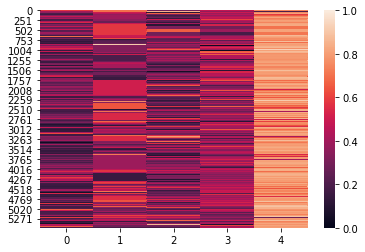

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing


X_perc =copy(X_all.filter(regex='%'))
X_perc.head()

min_max_scaler = preprocessing.MinMaxScaler()
X= X_all.loc[:,["%casespercapita","%", "unemployment rate", "median age", "% female" ]]

X_scaled = min_max_scaler.fit_transform(np.asarray(X))
y_scaled = min_max_scaler.fit_transform(np.asarray(y_all).reshape(-1,1))
sns.heatmap(X_scaled)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm


#y_all = (np.log(wmeans) - np.average(np.log(wmeans)))/np.std(np.log(wmeans))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[-0.06514493 -0.0216617  -0.00037425 -0.01073489  0.01392688]]
Mean squared error: 0.01
Coefficient of determination: 0.01
